## Gaussian Process Regression: Proof of Concepts

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.optimize import minimize,basinhopping,shgo
from numpy.linalg import cholesky
from numpy.random import normal
import traceback
from scipy.spatial.distance import euclidean
from scipy.linalg import solve_triangular
from random import uniform
from scipy.stats import norm

In [2]:
# global noise control
noise = 1e-6 # numerical convenience to avoid singular matrix

### Kernel function

In [3]:
# RBF + WHITENOISE KERNEL
def cov_rbf(X1,X2,gamma=1, noise=noise):
    """
    args:
    X1,X2: list of array
    gamma: free parameter of RBF kernel, see https://scikit-learn.org/stable/modules/metrics.html#rbf-kernel 
    noise: std of Gaussian white noise
    """
    N1, N2 = len(X1), len(X2)
    cov = np.zeros([N1,N2])
    for i in range(N1):
        x1 = X1[i]
        for j in range(N2):
            x2 = X2[j]
            # RBF
            cov[i,j] = np.exp(-gamma*euclidean(x1,x2)**2)
    white_kernel = np.eye(N1,N2)*noise**2
    return cov + white_kernel

### Objective

In [4]:
def objective(x, noise = noise):
    return x * np.sin(x) + normal(loc=0.0, scale=noise)

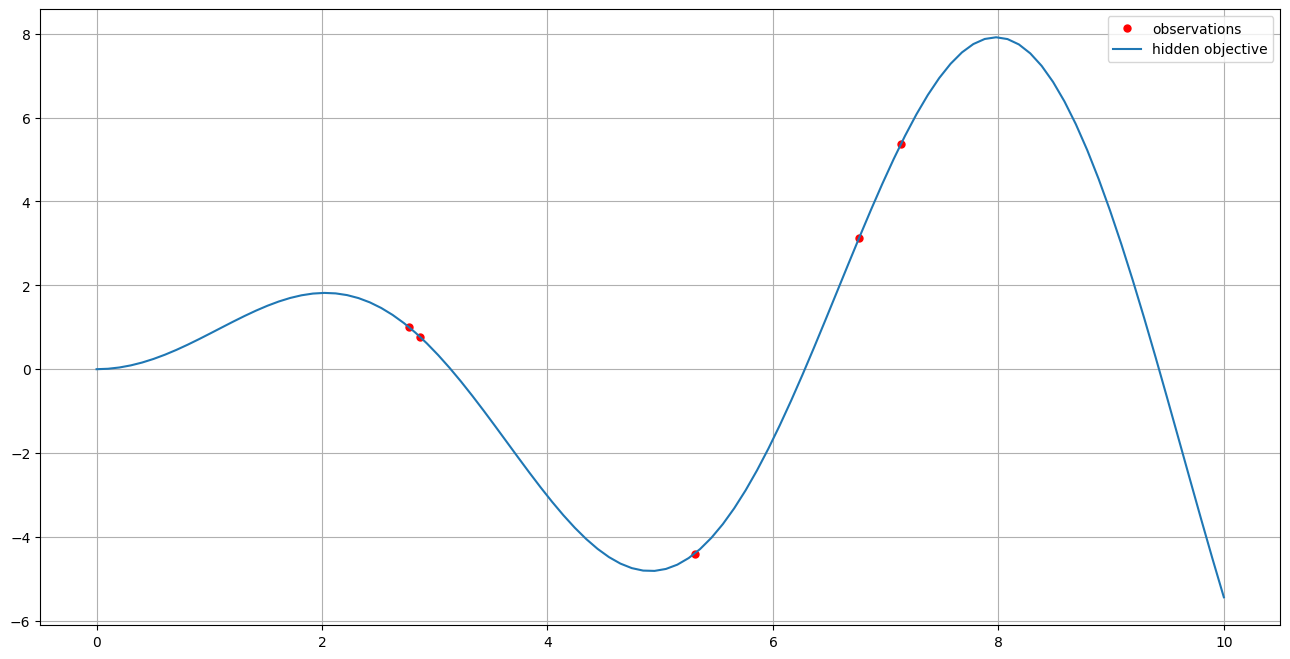

In [5]:
# OBSERVATIONS
minX, maxX = 0,10

x_observed = np.array(sorted(maxX*np.random.random(size=5)))
y_observed = np.array(objective(x_observed))

plt.figure(figsize=(16,8))
x_mesh = np.linspace(minX, maxX, 100)
y_mesh = objective(x_mesh)

plt.plot(x_observed, y_observed, 'r.', markersize=10, label='observations')
plt.plot(x_mesh,y_mesh, label='hidden objective')
plt.legend()
plt.grid()

### Optimize kernel parameter

In [6]:
def dtrtri(K):
    '''
    invert covariance matrix with Cholesky decomposition
    args:
    K: symmetric positive-definite matrix
    returns:
    L: Cholesky decomposition, lower triangular
    K_inv: inverse of K
    '''
    L = cholesky(K)
    L_inv = solve_triangular(L, np.identity(L.shape[0]),lower=True) # should be dtrtri, complex to O(N**2)
    K_inv = np.dot(L_inv.T,L_inv)
    return L, K_inv

In [7]:
def negative_log_likelihood(theta,observations):
    '''
    negative log likelihood of observations
    args:
    - theta: gamma and noise, free parameters of the kernel function
    - observations: (x_observed, y_observed)
    returns: 
    - nll: negative log likelihood of the observations
    '''
    gamma,noise = theta
    x_observed,y_observed = observations
    K = cov_rbf(x_observed, x_observed, gamma=gamma, noise=noise)
    L,K_inv = dtrtri(K)
    # negative log likelihood
    nll = 0.5*(y_observed.T.dot(K_inv).dot(y_observed) + \
               len(x_observed) * np.log(2*np.pi) + \
                     2*np.sum(np.log(np.diagonal(L))))
    return nll

In [8]:
observations = (x_observed,y_observed)
kernel_res = minimize(negative_log_likelihood, x0=[1,noise], args=(observations,), bounds=[(1e-5, None), (noise, noise)])
gamma_opt,noise_opt = kernel_res.x
gamma_opt,noise_opt

ValueError: Input vector should be 1-D.

### Predictions

In [9]:
# plot mesh predictions
C = cov_rbf(x_observed,x_observed,gamma = gamma_opt, noise = noise_opt)
x_pred = sorted(np.append(x_mesh,x_observed))
k0 = cov_rbf(x_pred,x_pred,gamma = gamma_opt, noise = noise_opt)
k = cov_rbf(x_pred, x_observed, gamma = gamma_opt, noise = noise_opt)

L, C_inverse = dtrtri(C)
mu = k.dot(C_inverse).dot(y_observed)
cov_pred = k0 -  k.dot(C_inverse).dot(k.T)
var_pred = np.diag(cov_pred)
# numerical problem may give negative variance
var_pred = var_pred.clip(min = 0)
sigma_pred = np.sqrt(var_pred)
pred_lower_boud = mu - 1.96*np.sqrt(var_pred)
pred_upper_boud = mu + 1.96*np.sqrt(var_pred)
# lower confidence bound
lcb_pred = mu - 1*np.sqrt(var_pred)
# ei
f_star = np.min(y_observed)
l = (f_star - mu)/sigma_pred
ei_pred = (f_star-mu)*norm.cdf(l)+sigma_pred*norm.pdf(l)
# for plotting
ei_pred = ei_pred*30

NameError: name 'gamma_opt' is not defined

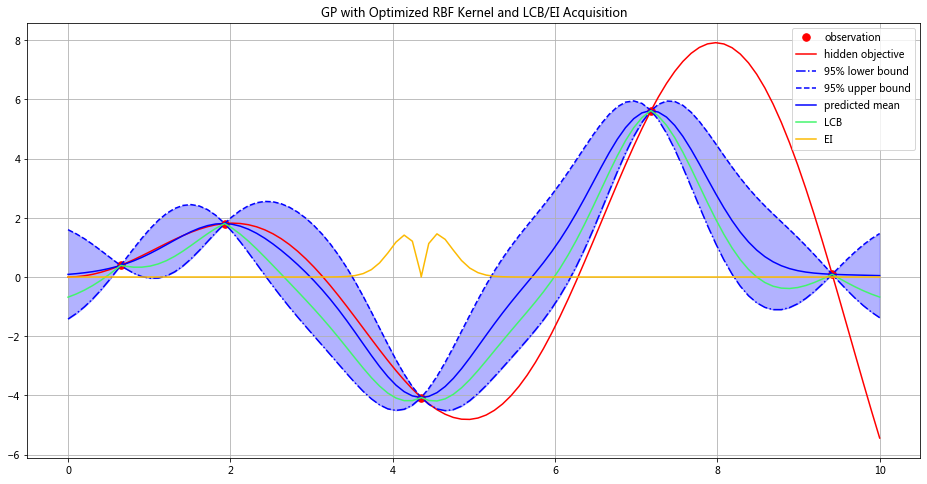

In [154]:
plt.figure(figsize=(16,8))
plt.plot(x_observed, y_observed, 'r.', markersize=15, label='observation', marker = '.')
plt.plot(x_mesh,y_mesh,color = 'r', label='hidden objective')
plt.plot(x_pred, pred_lower_boud,color='blue',linestyle='-.', label = '95% lower bound')
plt.plot(x_pred, pred_upper_boud,color='blue',linestyle='dashed', label = '95% upper bound')
plt.plot(x_pred,mu,color = 'b', label='predicted mean')
plt.fill_between(x_pred,pred_lower_boud,pred_upper_boud, color = 'blue',alpha=0.3)
plt.plot(x_pred,lcb_pred,color = '#42f56c', label='LCB')
plt.plot(x_pred,ei_pred,color = '#fcba03', label='EI')
plt.title('GP with Optimized RBF Kernel and LCB/EI Acquisition')
plt.legend()
plt.grid()

### Acquisition function && gradient descent

**Lower Confidence Bound**

In [155]:
def lcb(index,weight=1):
    """
    args: 
    index: array like, single point in index space
    weight: weight of std compared to mean
    
    return:
    lcb: negative LOWER confidence bound of the input index
    """
    # some useful covariance components
    point_to_pred = [index]
    k0 = cov_rbf(point_to_pred,point_to_pred,gamma=gamma_opt,noise=noise_opt)
    k = cov_rbf(point_to_pred, x_observed,gamma=gamma_opt,noise=noise_opt)
    mu = k.dot(C_inverse).dot(y_observed)
    cov_pred = k0 -  k.dot(C_inverse).dot(k.T)
    var_pred = np.diag(cov_pred)
    # numerical problem may give negative variance
    var_pred = var_pred.clip(min =0)
    return (mu - weight*np.sqrt(var_pred))[0]

In [156]:
# multi start gradient descent
multi_start_num = 10
start_points = np.array(sorted(maxX*np.random.random(size=multi_start_num)))
local_opt_x = []
local_opt_y = []
for start_point in start_points:
    res = minimize(lcb, x0 = (start_point,), 
                   bounds=[(0, maxX)],
                   method='L-BFGS-B')
    print(res.message)
    local_opt_x.append(res.x)
    local_opt_y.append(lcb(res.x))

# approx. global optimum
x_opt = local_opt_x[np.argmin(local_opt_y)][0]
x_opt

b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


4.5143103093582395

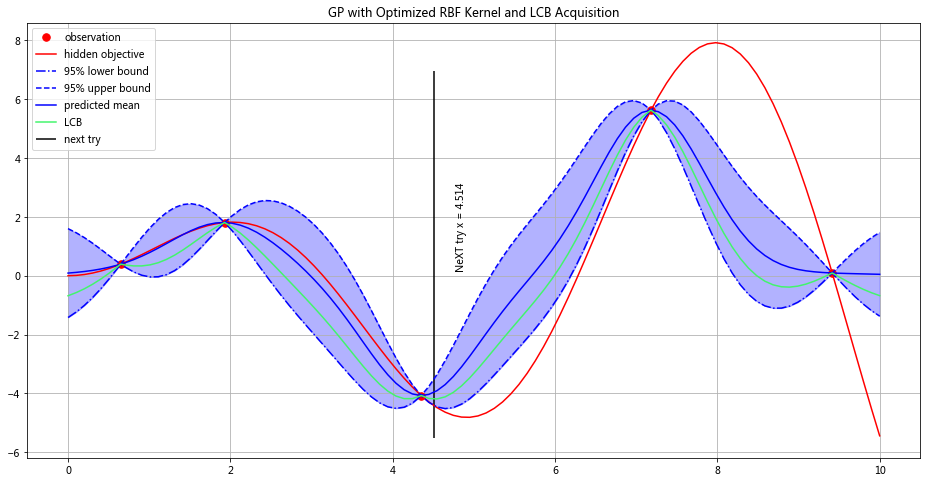

In [157]:
plt.figure(figsize=(16,8))
plt.plot(x_observed, y_observed, 'r.', markersize=15, label='observation', marker = '.')
plt.plot(x_mesh,y_mesh,color = 'r', label='hidden objective')
plt.plot(x_pred, pred_lower_boud,color='blue',linestyle='-.', label = '95% lower bound')
plt.plot(x_pred, pred_upper_boud,color='blue',linestyle='dashed', label = '95% upper bound')
plt.plot(x_pred,mu,color = 'b', label='predicted mean')
plt.fill_between(x_pred,pred_lower_boud,pred_upper_boud, color = 'blue',alpha=0.3)
plt.plot(x_pred,lcb_pred,color = '#42f56c', label='LCB')
plt.vlines(x_opt, ymin = min(pred_lower_boud) - 1, ymax = max(pred_upper_boud) + 1, label = 'next try')
plt.text(x_opt + 0.25,(min(pred_lower_boud) + max(pred_lower_boud)) / 5, 
         'NeXT try x = {x_opt}'.format(x_opt = round(x_opt,3)), rotation=90)
plt.title('GP with Optimized RBF Kernel and LCB Acquisition')
plt.legend()
plt.grid()

**Expected Improvement**

In [158]:
def nei(index):
    """
    args: 
    index: array like, single point in index space

    return:
    nei: negative expected improvement of the input index (to minimize)
    """
    point_to_pred = [index]
    k0 = cov_rbf(point_to_pred,point_to_pred,gamma=gamma_opt,noise=noise_opt)
    k = cov_rbf(point_to_pred, x_observed,gamma=gamma_opt,noise=noise_opt)
    mu = k.dot(C_inverse).dot(y_observed)[0]
    cov_pred = k0 -  k.dot(C_inverse).dot(k.T)
    var_pred = np.diag(cov_pred)[0]
    # numerical problem may give negative variance
    var_pred = var_pred.clip(min =0)
    sigma_pred = np.sqrt(var_pred)

    l = (f_star - mu)/sigma_pred
    ei = (f_star-mu)*norm.cdf(l)+sigma_pred*norm.pdf(l)
    return -1*ei # to minimize

In [159]:
# multi start gradient descent
multi_start_num = 10
start_points = np.array(sorted(maxX*np.random.random(size=multi_start_num)))
local_opt_x = []
local_opt_y = []
for start_point in start_points:
    res = minimize(nei, x0 = (start_point,), 
                   bounds=[(0, maxX)],
                   method='L-BFGS-B')
    print(res.message)
    local_opt_x.append(res.x)
    local_opt_y.append(nei(res.x))
# approx. global optimum
x_opt = local_opt_x[np.argmin(local_opt_y)][0]
x_opt

b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


4.546146204633625

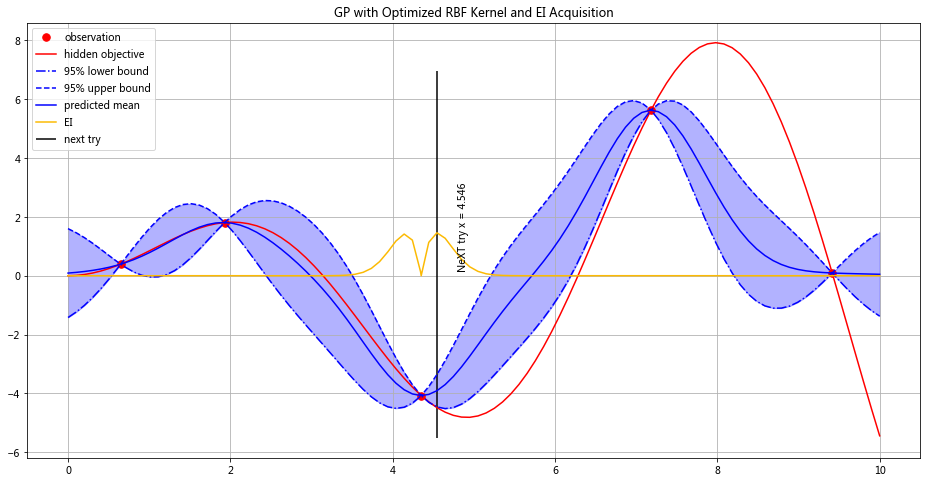

In [160]:
plt.figure(figsize=(16,8))
plt.plot(x_observed, y_observed, 'r.', markersize=15, label='observation', marker = '.')
plt.plot(x_mesh,y_mesh,color = 'r', label='hidden objective')
plt.plot(x_pred, pred_lower_boud,color='blue',linestyle='-.', label = '95% lower bound')
plt.plot(x_pred, pred_upper_boud,color='blue',linestyle='dashed', label = '95% upper bound')
plt.plot(x_pred,mu,color = 'b', label='predicted mean')
plt.fill_between(x_pred,pred_lower_boud,pred_upper_boud, color = 'blue',alpha=0.3)

plt.plot(x_pred,ei_pred,color = '#fcba03', label='EI')
plt.vlines(x_opt, ymin = min(pred_lower_boud) - 1, ymax = max(pred_upper_boud) + 1, label = 'next try')
plt.text(x_opt + 0.25,(min(pred_lower_boud) + max(pred_lower_boud)) / 5, 
         'NeXT try x = {x_opt}'.format(x_opt = round(x_opt,3)), rotation=90)
plt.title('GP with Optimized RBF Kernel and EI Acquisition')
plt.legend()
plt.grid()

### Put together

**LCB as acquisition**

In [161]:
# OBSERVATIONS
minX, maxX = 0,10

x_observed = np.array(maxX*np.random.random(size=5))
y_observed = np.array(objective(x_observed))
# for plot use
x_mesh = np.linspace(minX, maxX, 100)
y_mesh = objective(x_mesh)

b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


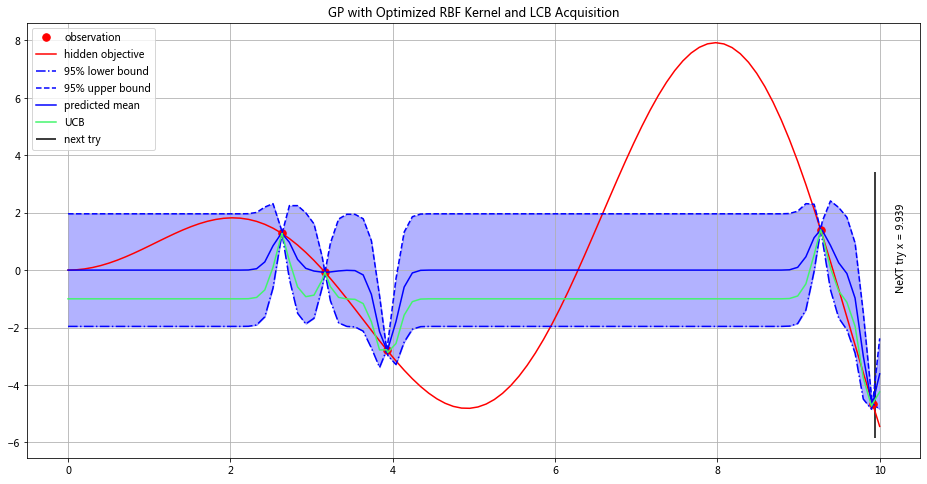

In [162]:
# optimize kernel
observations = (x_observed,y_observed)
kernel_res = minimize(negative_log_likelihood, x0=[1,noise], args=(observations,), bounds=[(1e-5, None), (noise, noise)])
gamma_opt,noise_opt = kernel_res.x

# plot mesh predictions
C = cov_rbf(x_observed,x_observed,gamma = gamma_opt, noise = noise_opt)
x_pred = sorted(np.append(x_mesh,x_observed))
k0 = cov_rbf(x_pred,x_pred,gamma = gamma_opt, noise = noise_opt)
k = cov_rbf(x_pred, x_observed, gamma = gamma_opt, noise = noise_opt)

L, C_inverse = dtrtri(C)
mu = k.dot(C_inverse).dot(y_observed)
cov_pred = k0 -  k.dot(C_inverse).dot(k.T)
var_pred = np.diag(cov_pred)
# numerical problem may give negative variance
var_pred = var_pred.clip(min = 0)

pred_lower_boud = mu - 1.96*np.sqrt(var_pred)
pred_upper_boud = mu + 1.96*np.sqrt(var_pred)
lcb_pred = mu - 1*np.sqrt(var_pred)

# multi start gradient descent
multi_start_num = 10
start_points = np.array(sorted(maxX*np.random.random(size=multi_start_num)))
local_opt_x = []
local_opt_y = []
for start_point in start_points:
    res = minimize(lcb, x0 = (start_point,), 
                   bounds=[(0, maxX)],
                   method='L-BFGS-B')
    print(res.message)
    local_opt_x.append(res.x)
    local_opt_y.append(lcb(res.x))

# approx. global optimum
x_opt = local_opt_x[np.argmin(local_opt_y)][0]

plt.figure(figsize=(16,8))
plt.plot(x_observed, y_observed, 'r.', markersize=15, label='observation', marker = '.')
plt.plot(x_mesh,y_mesh,color = 'r', label='hidden objective')
plt.plot(x_pred, pred_lower_boud,color='blue',linestyle='-.', label = '95% lower bound')
plt.plot(x_pred, pred_upper_boud,color='blue',linestyle='dashed', label = '95% upper bound')
plt.plot(x_pred,mu,color = 'b', label='predicted mean')
plt.fill_between(x_pred,pred_lower_boud,pred_upper_boud, color = 'blue',alpha=0.3)
plt.plot(x_pred,lcb_pred,color = '#42f56c', label='UCB')
plt.vlines(x_opt, ymin = min(pred_lower_boud) - 1, ymax = max(pred_upper_boud) + 1, label = 'next try')
plt.text(x_opt + 0.25,(min(pred_lower_boud) + max(pred_lower_boud)) / 5, 
         'NeXT try x = {x_opt}'.format(x_opt = round(x_opt,3)), rotation=90)
plt.title('GP with Optimized RBF Kernel and LCB Acquisition')
plt.legend()
plt.grid()

x_observed = np.append(x_observed, x_opt)
y_observed = objective(x_observed)

**EI as acquisition**

In [163]:
# OBSERVATIONS
minX, maxX = 0,10

x_observed = np.array(maxX*np.random.random(size=5))
y_observed = np.array(objective(x_observed))
# for plot use
x_mesh = np.linspace(minX, maxX, 100)
y_mesh = objective(x_mesh)

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


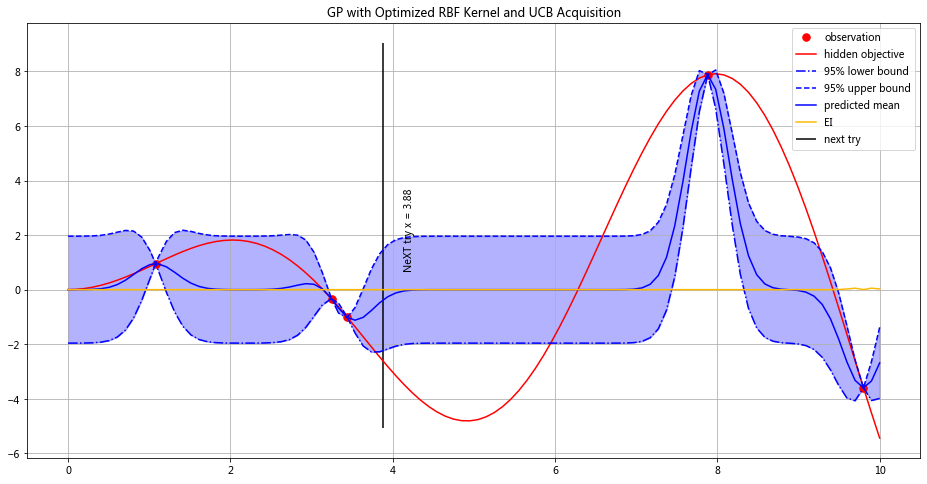

In [164]:
# optimize kernel
observations = (x_observed,y_observed)
kernel_res = minimize(negative_log_likelihood, x0=[1,noise], args=(observations,), bounds=[(1e-5, None), (noise, noise)])
gamma_opt,noise_opt = kernel_res.x

# plot mesh predictions
C = cov_rbf(x_observed,x_observed,gamma = gamma_opt, noise = noise_opt)
x_pred = sorted(np.append(x_mesh,x_observed))
k0 = cov_rbf(x_pred,x_pred,gamma = gamma_opt, noise = noise_opt)
k = cov_rbf(x_pred, x_observed, gamma = gamma_opt, noise = noise_opt)

L, C_inverse = dtrtri(C)
mu = k.dot(C_inverse).dot(y_observed)
cov_pred = k0 -  k.dot(C_inverse).dot(k.T)
var_pred = np.diag(cov_pred)
# numerical problem may give negative variance
var_pred = var_pred.clip(min = 0)
sigma_pred = np.sqrt(var_pred)

pred_lower_boud = mu - 1.96*np.sqrt(var_pred)
pred_upper_boud = mu + 1.96*np.sqrt(var_pred)

# ei
f_star = np.min(y_observed)
l = (f_star - mu)/sigma_pred
ei_pred = (f_star-mu)*norm.cdf(l)+sigma_pred*norm.pdf(l)

# multi start gradient descent
multi_start_num = 10
start_points = np.array(sorted(maxX*np.random.random(size=multi_start_num)))
local_opt_x = []
local_opt_y = []
for start_point in start_points:
    res = minimize(nei, x0 = (start_point,), 
                   bounds=[(0, maxX)],
                   method='L-BFGS-B')
    print(res.message)
    local_opt_x.append(res.x)
    local_opt_y.append(nei(res.x))

# approx. global optimum
x_opt = local_opt_x[np.argmin(local_opt_y)][0]

plt.figure(figsize=(16,8))
plt.plot(x_observed, y_observed, 'r.', markersize=15, label='observation', marker = '.')
plt.plot(x_mesh,y_mesh,color = 'r', label='hidden objective')
plt.plot(x_pred, pred_lower_boud,color='blue',linestyle='-.', label = '95% lower bound')
plt.plot(x_pred, pred_upper_boud,color='blue',linestyle='dashed', label = '95% upper bound')
plt.plot(x_pred,mu,color = 'b', label='predicted mean')
plt.fill_between(x_pred,pred_lower_boud,pred_upper_boud, color = 'blue',alpha=0.3)
plt.plot(x_pred,ei_pred,color = '#fcba03', label='EI')
plt.vlines(x_opt, ymin = min(pred_lower_boud) - 1, ymax = max(pred_upper_boud) + 1, label = 'next try')
plt.text(x_opt + 0.25,(min(pred_lower_boud) + max(pred_lower_boud)) / 5, 
         'NeXT try x = {x_opt}'.format(x_opt = round(x_opt,3)), rotation=90)
plt.title('GP with Optimized RBF Kernel and UCB Acquisition')
plt.legend()
plt.grid()

x_observed = np.append(x_observed, x_opt)
y_observed = objective(x_observed)

---

### 2D Demo

In [165]:
# Objective function
def Himmelblau(params, noise=noise):
    """
    noisy Himmelblau function
    https://en.wikipedia.org/wiki/Test_functions_for_optimization
    """
    x,y = params
    objective = (x**2+y-11)**2+(x+y**2-7)**2 + noise*np.random.normal(0, 1)
    return objective

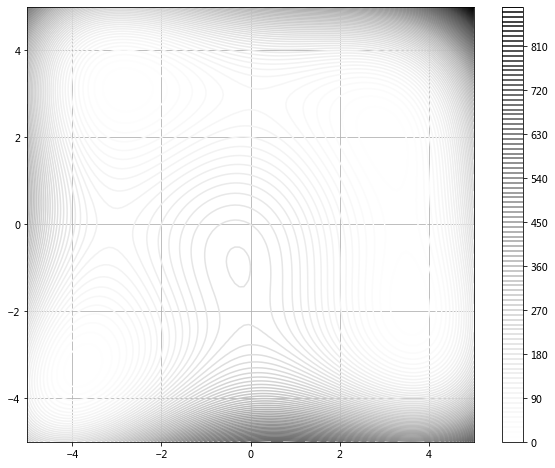

In [166]:
# search space
minX, maxX, minY, maxY = -5., 5., -5., 5.
x, y = np.meshgrid(np.linspace(minX, maxX, 100),np.linspace(minY, maxY, 100))
plt.figure(figsize=(10,8))
plt.contour(x, y, Himmelblau((x, y)),levels=100,cmap = 'Greys')
plt.colorbar()
plt.grid()

**LCB**

In [167]:
# observations
# number of observation
M = 3
x_observed = np.random.uniform(low=minX, high=maxX, size=(M,2))
y_observed = np.array([Himmelblau(x) for x in x_observed])

b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENC

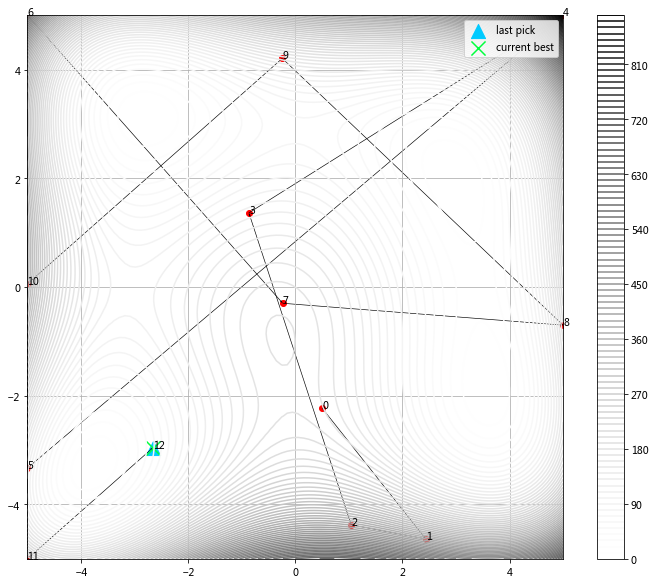

In [168]:
STEPS = 10
for _ in range(STEPS):
    # optimize kernel parameter
    observations = (x_observed,y_observed)
    kernel_res = minimize(negative_log_likelihood, x0=[1,noise], args=(observations,), bounds=[(1e-5, None), (noise, noise)])
    gamma_opt,noise_opt = kernel_res.x

    # plot mesh predictions
    C = cov_rbf(x_observed,x_observed,gamma = gamma_opt, noise = noise_opt)
    # k0 = cov_rbf(mesh_points,mesh_points,gamma = gamma_opt, noise = noise_opt)
    # k = cov_rbf(mesh_points, x_observed, gamma = gamma_opt, noise = noise_opt)

    L, C_inverse = dtrtri(C)
    # mu = k.dot(C_inverse).dot(y_observed)
    # cov_pred = k0 -  k.dot(C_inverse).dot(k.T)
    # var_pred = np.diag(cov_pred)
    # # numerical problem may give negative variance
    # var_pred = var_pred.clip(min = 0)
    # utility = mu - 1*np.sqrt(var_pred)

    # multi start gradient descent
    multi_start_num = 10
    start_points = [] 
    for _ in range(multi_start_num):
        _x,_y = uniform(minX,maxX), uniform(minY,maxY)
        start_points.append((_x,_y))

    local_opt_x = []
    local_opt_y = []

    for start_point in start_points:
        _x,_y = start_point
        res = minimize(lcb, x0 = (_x,_y), 
                       bounds=[(minX, maxX),(minY, maxY)],
                       method='L-BFGS-B')
        print(res.message)
        local_opt_x.append(res.x)
        local_opt_y.append(lcb(res.x))

    next_try = local_opt_x[np.argmin(local_opt_y)]

    x_observed = np.concatenate((x_observed,np.array([next_try])))
    y_observed = np.append(y_observed, Himmelblau(next_try))

# contour
plt.figure(figsize=(12,10))
plt.contour(x, y, Himmelblau((x, y)),levels=100,cmap = 'Greys')
plt.colorbar()

# scatter
x1 = np.array([_[0] for _ in x_observed])
x2 = np.array([_[1] for _ in x_observed])
plt.scatter(x=x1[:-1], y=x2[:-1],color='r')

# the latest point
last_x1,last_x2 = x1[-1],x2[-1]
plt.scatter(x =last_x1,y=last_x2,color='#00CAFF',marker = '^',s = 200, label = 'last pick')

# arrow trace
plt.quiver(x1[:-1], x2[:-1], x1[1:]-x1[:-1], x2[1:]-x2[:-1], scale_units='xy', angles='xy', scale=1, width = 0.0012)
# index text
for i in range(len(x1)):
    plt.text(x1[i], x2[i], str(i))
# best candidate
best_x,best_y = x_observed[np.argmin(y_observed)]
plt.scatter(x =best_x, y=best_y,color='#00FF3D',marker = 'x',s = 200, label = 'current best')
# plt.text(best_x, best_y, 'our choice',size = 30)
plt.legend()
plt.xlim(minX,maxX)
plt.ylim(minY,maxY)
plt.grid()

**EI**

In [169]:
# observations
# number of observation
M = 3
x_observed = np.random.uniform(low=minX, high=maxX, size=(M,2))
y_observed = np.array([Himmelblau(x) for x in x_observed])

b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
b'CONVERGENC

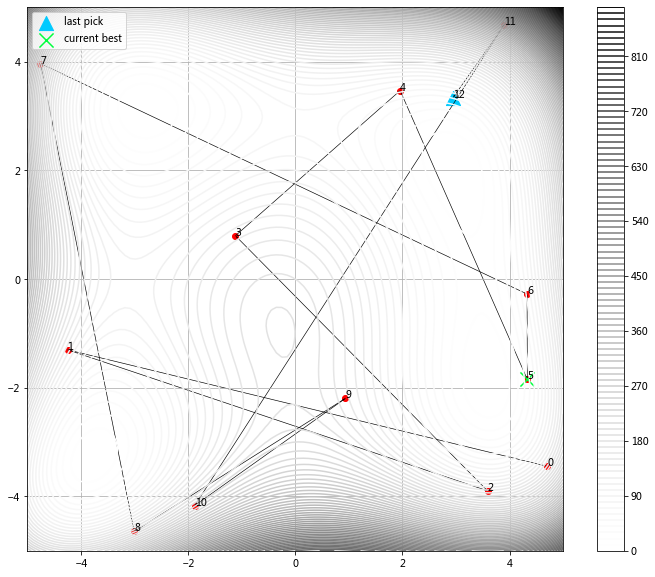

In [170]:
STEPS = 10
for _ in range(STEPS):
    # optimize kernel parameter
    observations = (x_observed,y_observed)
    kernel_res = minimize(negative_log_likelihood, x0=[1,noise], args=(observations,), bounds=[(1e-5, None), (noise, noise)])
    gamma_opt,noise_opt = kernel_res.x

    # plot mesh predictions
    C = cov_rbf(x_observed,x_observed,gamma = gamma_opt, noise = noise_opt)
    # k0 = cov_rbf(mesh_points,mesh_points,gamma = gamma_opt, noise = noise_opt)
    # k = cov_rbf(mesh_points, x_observed, gamma = gamma_opt, noise = noise_opt)

    L, C_inverse = dtrtri(C)
    # mu = k.dot(C_inverse).dot(y_observed)
    # cov_pred = k0 -  k.dot(C_inverse).dot(k.T)
    # var_pred = np.diag(cov_pred)
    # # numerical problem may give negative variance
    # var_pred = var_pred.clip(min = 0)
    # utility = mu - 1*np.sqrt(var_pred)

    # multi start gradient descent
    multi_start_num = 10
    start_points = [] 
    for _ in range(multi_start_num):
        _x,_y = uniform(minX,maxX), uniform(minY,maxY)
        start_points.append((_x,_y))

    local_opt_x = []
    local_opt_y = []

    for start_point in start_points:
        _x,_y = start_point
        res = minimize(nei, x0 = (_x,_y), 
                       bounds=[(minX, maxX),(minY, maxY)],
                       method='L-BFGS-B')
        print(res.message)
        local_opt_x.append(res.x)
        local_opt_y.append(nei(res.x))

    next_try = local_opt_x[np.argmin(local_opt_y)]

    x_observed = np.concatenate((x_observed,np.array([next_try])))
    y_observed = np.append(y_observed, Himmelblau(next_try))

# contour
plt.figure(figsize=(12,10))
plt.contour(x, y, Himmelblau((x, y)),levels=100,cmap = 'Greys')
plt.colorbar()

# scatter
x1 = np.array([_[0] for _ in x_observed])
x2 = np.array([_[1] for _ in x_observed])
plt.scatter(x=x1[:-1], y=x2[:-1],color='r')

# the latest point
last_x1,last_x2 = x1[-1],x2[-1]
plt.scatter(x =last_x1,y=last_x2,color='#00CAFF',marker = '^',s = 200, label = 'last pick')

# arrow trace
plt.quiver(x1[:-1], x2[:-1], x1[1:]-x1[:-1], x2[1:]-x2[:-1], scale_units='xy', angles='xy', scale=1, width = 0.0012)
# index text
for i in range(len(x1)):
    plt.text(x1[i], x2[i], str(i))
# best candidate
best_x,best_y = x_observed[np.argmin(y_observed)]
plt.scatter(x =best_x, y=best_y,color='#00FF3D',marker = 'x',s = 200, label = 'current best')
# plt.text(best_x, best_y, 'our choice',size = 30)
plt.legend()
plt.xlim(minX,maxX)
plt.ylim(minY,maxY)
plt.grid()